In [1]:
import polars as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
print(
    f"Polars version = {pl.__version__}, Numpy version = {np.__version__}"
)
%load_ext autoreload
%autoreload 2
from src import data_transformation
from src.model import prepare_lgbm_dataset_with_weights, train_or_load_lgbm, evaluate_model

Polars version = 1.32.2, Numpy version = 1.26.4


# 数据处理
<mark>后续可能会进一步封装代码，让这部分更简洁</mark>

In [2]:
from pathlib import Path
INPUTS = Path('./data/inputs')
INTERMEDIATES = Path('./data/intermediates')
OUTPUTS = Path('./data/outputs')

INPUTS.mkdir(parents=True, exist_ok=True)
INTERMEDIATES.mkdir(parents=True, exist_ok=True)
OUTPUTS.mkdir(parents=True, exist_ok=True)

In [3]:
## 
datasets = data_transformation.load_inputs(INPUTS)
intermediate_datasets_pth = {
    "merged_reserve": INTERMEDIATES/"merged_reserve.csv",
    "date_info": INTERMEDIATES/"date_info.csv",
    "merged_store_info": INTERMEDIATES/"merged_store_info.csv",
    "train_visit_data": INTERMEDIATES/"train_visit_data.csv",
    "test_visit_data": INTERMEDIATES/"test_visit_data.csv"
}

if not intermediate_datasets_pth["merged_reserve"].exists():
    merged_reserve = data_transformation.merge_reservation(**datasets)
    merged_reserve.sink_csv(INTERMEDIATES/"merged_reserve.csv")

if not intermediate_datasets_pth["date_info"].exists():
    datasets["date_info"].sink_csv(INTERMEDIATES/"date_info.csv")

if not intermediate_datasets_pth["merged_store_info"].exists():
    datasets["air_store_info"].sink_csv(INTERMEDIATES/"merged_store_info.csv")

if not intermediate_datasets_pth["train_visit_data"].exists():
    datasets["air_visit_data"].filter(pl.col("visit_date") <= pl.lit("2017-03-10")).sink_csv(INTERMEDIATES/"train_visit_data.csv")
if not intermediate_datasets_pth["test_visit_data"].exists():
    datasets["air_visit_data"].filter(pl.col("visit_date") > pl.lit("2017-03-10")).sink_csv(INTERMEDIATES/"test_visit_data.csv")

In [4]:
output_datasets_pth = {
    "hpg_train": OUTPUTS/"hpg_train.parquet",
    "hpg_test": OUTPUTS/"hpg_test.parquet",
    "air_train": OUTPUTS/"air_train.parquet",
    "air_test": OUTPUTS/"air_test.parquet",
}

if any([not pth.exists() for pth in output_datasets_pth.values()]):
    train, test = data_transformation.add_features_pipeline(
        intermediate_datasets_pth["train_visit_data"],
        intermediate_datasets_pth["test_visit_data"],
        intermediate_datasets_pth["merged_reserve"],
        intermediate_datasets_pth["date_info"],
        intermediate_datasets_pth["merged_store_info"]
    )
    hpg_list = pd.read_parquet(INPUTS/"store_id_relation.parquet")["air_store_id"].tolist()

    train.query("air_store_id in @hpg_list").to_parquet(output_datasets_pth["hpg_train"])
    train.query("air_store_id not in @hpg_list").to_parquet(output_datasets_pth["air_train"])
    test.query("air_store_id in @hpg_list").to_parquet(output_datasets_pth["hpg_test"])
    test.query("air_store_id not in @hpg_list").to_parquet(output_datasets_pth["air_test"])

# 模型训练

In [5]:
# 源域
air_train = pd.read_parquet(OUTPUTS/"air_train.parquet")

# 目标域
hpg_train = pd.read_parquet(OUTPUTS/"hpg_train.parquet")
hpg_test = pd.read_parquet(OUTPUTS/"hpg_test.parquet")

x_cols = hpg_train.drop(columns = ["air_store_id","visit_date","visitors"]).columns.to_list()
y_cols = ["visitors"]
y_col = y_cols[0]

In [ ]:
hpg_train["air_area_name"]

In [24]:
data = pd.concat(
    (hpg_train[["air_area_name","air_store_id"]].assign(source="hpg"),air_train[["air_area_name","air_store_id"]].assign(source="air"))
)
# from matplotlib import pyplot as plt
# import seaborn as sns
# fig, ax = plt.subplots(figsize=(20,10))
# sns.histplot(x="air_genre_name", hue="source", data=data)
data.pivot_table(values = "air_store_id", index = "air_area_name", columns = "source", aggfunc = "count").to_csv("area_count.csv")

**看看长啥样**

In [13]:
from visualization import  air_hpg_visualization
top_air, mid_air, low_air, hpg = air_hpg_visualization(air_train, hpg_train, x_cols + y_cols)

Running t-SNE for (X,y) joint distribution...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10972 samples in 0.012s...
[t-SNE] Computed neighbors for 10972 samples in 3.989s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10972
[t-SNE] Computed conditional probabilities for sample 2000 / 10972
[t-SNE] Computed conditional probabilities for sample 3000 / 10972
[t-SNE] Computed conditional probabilities for sample 4000 / 10972
[t-SNE] Computed conditional probabilities for sample 5000 / 10972
[t-SNE] Computed conditional probabilities for sample 6000 / 10972
[t-SNE] Computed conditional probabilities for sample 7000 / 10972
[t-SNE] Computed conditional probabilities for sample 8000 / 10972
[t-SNE] Computed conditional probabilities for sample 9000 / 10972
[t-SNE] Computed conditional probabilities for sample 10000 / 10972
[t-SNE] Computed conditional probabilities for sample 10972 / 10972
[t-SNE] Mean sigma: 4.121202
[t-SNE] Computed conditional probabilities 

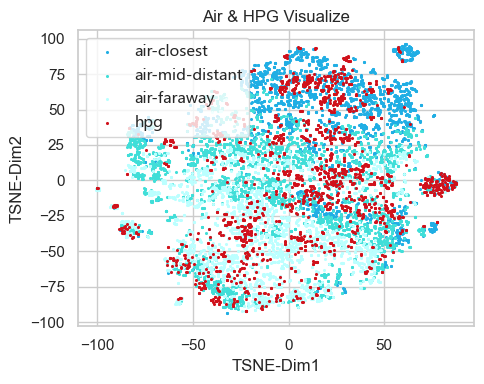

In [55]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.rcParams['font.family'] = 'Microsoft YaHei'
for label, data, color in zip(
    ["air-closest", "air-mid-distant", "air-faraway"], 
    [top_air, mid_air, low_air],
    ["#20AEE4","#40DED8","#BBFFFF"]
):
    ax.scatter(data[:,0], data[:,1], label=label, c = color, linewidths=0,s=5)
    #break
ax.scatter(hpg[:,0], hpg[:,1], label="hpg", c = "#D0111B", linewidths=0,s=5)
ax.set(xlabel="TSNE-Dim1",ylabel="TSNE-Dim2",title="Air & HPG Visualize")
# 将legend移到图片上方，不显示边框
#plt.legend(bbox_to_anchor=(0.5, 1.02), loc='lower center', frameon=False)
plt.legend()
plt.tight_layout()

In [62]:
import numpy as np
from scipy.stats import pearsonr

def xy_corr(data, x_cols, y_cols):
    # 只计算y列与x列之间的相关性
    y_data = data[y_cols].values
    x_data = data[x_cols].values

    correlations = {}
    for i, y_col in enumerate(y_cols):
        correlations[y_col] = {}
        for j, x_col in enumerate(x_cols):
            corr, _ = pearsonr(y_data[:, i], x_data[:, j])
            correlations[y_col][x_col] = corr

    return pd.DataFrame(correlations)  # 转置以匹配原来的方向1

corr1 = xy_corr(air_train, x_cols, y_cols)
corr2 = xy_corr(hpg_train, x_cols, y_cols)
corr = corr1.join(corr2,lsuffix="air", rsuffix="hpg")

In [65]:
corr.to_csv("corr.csv")

In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 假设你已经有以下数据
# air_train: 源域数据 (AIR)
# hpg_train: 目标域数据 (HPG)
# x_cols: 特征列名列表

# 从super_ensemble.py中获取中间数据
from src.model.super_ensemble import smart_sample_selection, adaptive_feature_alignment

# 1. CoRAL前的数据 (智能样本筛选前的源域数据)
source_before_coral = air_train[x_cols].copy()
print("Source data before CoRAL:", source_before_coral.shape)

# 2. 目标域数据
target_data = hpg_train[x_cols].copy()
print("Target data:", target_data.shape)

# 3. 应用智能样本筛选 (CoRAL前的样本筛选)
selected_source_data = smart_sample_selection(
    air_train, hpg_train, x_cols, n_clusters=20, selection_ratio=0.7
)
source_after_selection = selected_source_data[x_cols].copy()
print("Source data after sample selection:", source_after_selection.shape)

# 4. 应用自适应特征对齐 (CoRAL后)
aligned_source_data = adaptive_feature_alignment(
    selected_source_data, hpg_train, x_cols
)
source_after_coral = aligned_source_data[x_cols].copy()
print("Source data after CoRAL:", source_after_coral.shape)

Source data before CoRAL: (178379, 260)
Target data: (39760, 260)
Source data after sample selection: (124865, 260)
Source data after CoRAL: (124865, 260)


In [9]:
from sklearn.manifold import TSNE
# 获取经样本选择后的源域数据 (CORAL处理前)
source_before_coral = source_after_selection[x_cols].copy()

# 获取经CORAL对齐后的源域数据 (相同样本)
source_after_coral = source_after_coral[x_cols].copy()

# 合并数据用于统一t-SNE降维
combined_data = pd.concat([
    source_before_coral.assign(domain='before_coral').sample(2000, random_state=42),
    source_after_coral.assign(domain='after_coral').sample(3500, random_state=21),
    target_data.assign(domain='target').sample(3500, random_state=84)
], axis=0, ignore_index=True)

# 应用t-SNE降维
tsne = TSNE(n_components=2, random_state=42, verbose=1)
combined_tsne = tsne.fit_transform(combined_data.drop('domain', axis=1))

# 分离降维结果
before_mask = combined_data['domain'] == 'before_coral'
after_mask = combined_data['domain'] == 'after_coral'
target_mask = combined_data['domain'] == 'target'

tsne_before = combined_tsne[before_mask]
tsne_after = combined_tsne[after_mask]
tsne_target = combined_tsne[target_mask]

# 输出形状确认
print("t-SNE results:")
print("- Before CORAL:", tsne_before.shape)
print("- After CORAL:", tsne_after.shape)
print("- Target:", tsne_target.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.008s...
[t-SNE] Computed neighbors for 9000 samples in 0.262s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 371.992105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.678192
[t-SNE] KL divergence after 1000 iterations: 0.597159
t-SNE results:
- Before CORAL: (2000, 2)
- After CORAL: (3500, 2)
- Target: (3500, 2)


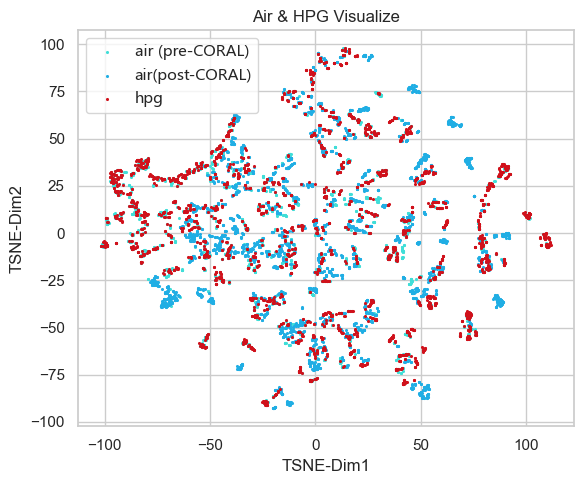

In [10]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.rcParams['font.family'] = 'Microsoft YaHei'
for label, data, color in zip(
    ["air (pre-CORAL)", "air(post-CORAL)","hpg"], 
    [tsne_before,tsne_after,tsne_target],
    ["#40DED8","#20AEE4","#D0111B"]
):
    ax.scatter(data[:,0], data[:,1], label=label, c = color, linewidths=0,s=5)

ax.set(xlabel="TSNE-Dim1",ylabel="TSNE-Dim2",title="Air & HPG Visualize")
# 将legend移到图片上方，不显示边框
#plt.legend(bbox_to_anchor=(0.5, 1.02), loc='lower center', frameon=False)
plt.legend()
plt.tight_layout()

## Baseline
baseline 的 `RMSLE` = 0.5664

In [16]:
# Baseline Model

# 1. 准备数据（自动从训练数据中划分训练集和验证集）
train_matrix, valid_matrix, te_x, te_y = prepare_lgbm_dataset_with_weights(
    train_data=hpg_train,    # 完整的训练数据
    test_data=hpg_test,      # 测试数据
    x_cols=x_cols,
    y_cols=y_cols,
    weight_col='day_gap',
    valid_days=7             # 使用最近7天作为验证集
)

# 2. 训练或加载模型
model = train_or_load_lgbm(
    train_matrix=train_matrix,
    valid_matrix=valid_matrix,    # 使用验证集进行早停
    model_path='./lgbm_weights/hpg_model.pkl'
)

# 3. 评估模型
results = evaluate_model(model, te_x, te_y)
print(f"RMSLE Score: {results['rmsle']:.4f}")

Train data date range: 2016-01-16 to 2017-03-03
Valid data date range: 2017-03-04 to 2017-03-10
Train samples: 38841, Valid samples: 919
Training model with early stopping...
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1103]	valid_0's rmse: 0.549814
Model saved to ./lgbm_weights/hpg_model.pkl
RMSLE Score: 0.5664


## 迁移学习部分

简单的样本迁移（用`air_train`训练模型，然后直接预测）<br>
`RMSLE` = 0.5603(<span style="color:green">-0.0063</span> vs baseline)

In [14]:
## 
train_matrix, valid_matrix, te_x, te_y = prepare_lgbm_dataset_with_weights(
    train_data=air_train,    # 样本迁移 air 的训练数据
    test_data=hpg_test,      # 测试数据
    x_cols=x_cols,
    y_cols=y_cols,
    weight_col='day_gap',
    valid_days=7            
)

# 2. 训练或加载模型
model = train_or_load_lgbm(
    train_matrix=train_matrix,
    valid_matrix=valid_matrix,    # 使用验证集进行早停
    model_path='./lgbm_weights/air_model.pkl'
)

# 3. 评估模型
results = evaluate_model(model, te_x, te_y)
print(f"RMSLE Score: {results['rmsle']:.4f}")

Train data date range: 2016-01-16 to 2017-03-03
Valid data date range: 2017-03-04 to 2017-03-10
Train samples: 174300, Valid samples: 4079
Loading model from ./lgbm_weights/air_model.pkl
RMSLE Score: 0.5603


如果进行微调呢？<br>
`RMSLE` = 0.5673(<span style="color:red">+0.0009</span> vs baseline)

In [12]:
# 迁移学习：源域预训练 -> 目标域微调
from src.model.transfer import finetune_from_source
FINETUNED_MODEL_PATH = Path("./lgbm_weights/air_to_hpg_finetuned.pkl")

finetune_result = finetune_from_source(
    train_data=hpg_train,
    test_data=hpg_test,
    x_cols=x_cols,
    y_cols=y_cols,
    source_model_path="./lgbm_weights/air_model.pkl",  # 先运行前面的源域训练单元生成
    finetuned_model_path=FINETUNED_MODEL_PATH,
    weight_col="day_gap",
    valid_days=7,
    learning_rate=1e-3,
    num_round=2000,
)


print("="*20)
print(f"Finetune RMSLE: {finetune_result['rmsle']:.4f}")
FINETUNED_MODEL_PATH.unlink()

Train data date range: 2016-01-16 to 2017-03-03
Valid data date range: 2017-03-04 to 2017-03-10
Train samples: 38841, Valid samples: 919
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4936]	valid_0's rmse: 0.55974
Finetune RMSLE: 0.5620


如果进行特征迁移呢？<br>
`RMSLE` = 0.5913(<span style="color:red">+0.0249</span> vs baseline)

In [ ]:
# 迁移学习：特征迁移（CORAL）
from src.model.transfer import coral_align_source_to_target

# 1) 将源域特征对齐到目标域分布
coral_air_train = coral_align_source_to_target(
    source_df=air_train,
    target_df=hpg_train,
    feature_cols=x_cols,
)

# 2) 使用对齐后的源域数据训练，在目标域测试集评估
coral_train_matrix, coral_valid_matrix, coral_te_x, coral_te_y = prepare_lgbm_dataset_with_weights(
    train_data=coral_air_train,
    test_data=hpg_test,
    x_cols=x_cols,
    y_cols=y_cols,
    weight_col='day_gap',
    valid_days=7,
)

coral_model = train_or_load_lgbm(
    train_matrix=coral_train_matrix,
    valid_matrix=coral_valid_matrix,
    model_path=None,
)

coral_results = evaluate_model(coral_model, coral_te_x, coral_te_y)
print("="*20)
print(f"CORAL RMSLE: {coral_results['rmsle']:.4f}")

Train data date range: 2016-01-16 to 2017-03-03
Valid data date range: 2017-03-04 to 2017-03-10
Train samples: 174300, Valid samples: 4079
Training model with early stopping...
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[3370]	valid_0's rmse: 0.469629
CORAL RMSLE: 0.5913
